# Prae-1 (EPIC 211916756) transit modelling

Prae-1 transit modelling assuming a Normal prior on logg with $\mu=4.81$, and $\sigma=0.08$.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm
from core import *
from plots import AAOCW, AAPGW

## Run DE and MCMC

In [3]:
npop, de_iter, mc_iter = 100, 200, 20000
lpf = LPFunction(logg_prior = NP(4.81, 0.08, 'logg', lims=(1,10)))
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

In [6]:
do_mcmc = True
do_mcmc = False

if do_mcmc:
    for r in tqdm(de(de_iter), total=de_iter): pass

    for i,r in enumerate(tqdm(sampler.sample(de.population, iterations=mc_iter, thin=100), total=mc_iter)):
        if ((i > 0) and (i%500 == 0)) or (i == mc_iter-1):
            savez('results/02c', chains=sampler.chain)
            
chain = load('results/02c.npz')['chains']
fc = chain[:,50:,:].reshape([-1,lpf.ps.ndim])
mp = median(fc, 0)

## Create the dataframe

In [7]:
import math as mt

pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['tcc'] = df.tc - floor(df.tc.mean())
df['pc'] = df.p - 10
df['ecc'] = df.secw**2+df.sesw**2
df['w'] = arctan2(df.sesw, df.secw)/pi
df['e'] *= 1e6
df['k'] = sqrt(df.k2)
df['a'] = as_from_rhop(df.rho, df.p)
df['I'] = np.rad2deg(arccos(df.b/df.a))
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df['T14'] = 24*T14(df.p, df.a, df.k, radians(df.I))
df = df.drop(['k2','q1','q2'], axis=1)
df.describe()
#print floor(df.tc.mean())

,tc,p,rho,b,secw,sesw,e,c,tcc,pc,ecc,w,k,a,I,u,v,T14
count,15000.0000,15000.0000,15000.0000,1.5000e+04,15000.0000,15000.0000,15000.0000,1.5000e+04,15000.0000,15000.0000,1.5000e+04,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000
mean,2317.8786,10.1344,7.7692,3.6351e-01,-0.0108,-0.4449,937.3145,1.0001e+00,0.8786,0.1344,4.0961e-01,-0.4907,0.0764,34.6755,89.3971,0.9859,-0.2176,2.1915
std,0.0015,0.0004,1.4645,2.4302e-01,0.4218,0.1833,25.7113,3.7343e-05,0.0015,0.0004,2.2910e-01,0.2701,0.0063,2.1607,0.4063,0.3796,0.3598,0.2792
min,2317.8726,10.1326,4.0019,3.4630e-05,-0.7843,-0.8000,830.6287,9.9998e-01,0.8726,0.1326,6.5077e-05,-0.9998,0.0617,27.9047,88.1449,0.0002,-0.9966,1.3487
25%,2317.8776,10.1341,6.6950,1.5485e-01,-0.3774,-0.5752,920.0036,1.0001e+00,0.8776,0.1341,2.2495e-01,-0.7273,0.0724,33.1260,89.0948,0.7377,-0.4814,2.0381
50%,2317.8786,10.1344,7.6243,3.2995e-01,-0.0155,-0.4417,937.1222,1.0001e+00,0.8786,0.1344,3.7514e-01,-0.5034,0.0752,34.5922,89.4525,0.9949,-0.2688,2.2399
75%,2317.8796,10.1347,8.7100,5.4831e-01,0.3563,-0.3293,954.2319,1.0002e+00,0.8796,0.1347,5.8228e-01,-0.2739,0.0787,36.1613,89.7451,1.2535,-0.0006,2.3900
max,2317.8852,10.1362,14.7442,9.4210e-01,0.7953,0.2840,1035.5480,1.0003e+00,0.8852,0.1362,9.4127e-01,0.9986,0.1087,43.0968,89.9999,1.9935,0.9769,2.9375


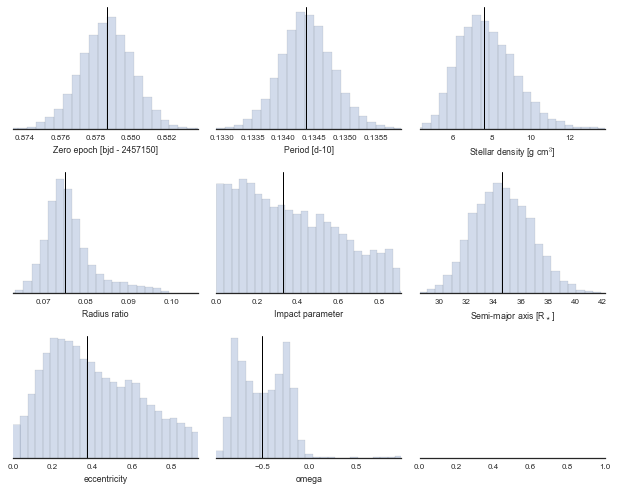

In [8]:
sb.set_context('paper')
fig,ax = subplots(3,3, figsize=(2.5*AAOCW,2*AAOCW))

pars = 'tcc pc rho k b a ecc w'.split()
labels = ('Zero epoch [bjd - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$], eccentricity, omega'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    df[par].hist(bins=25, normed=True, alpha=0.25, grid=False, ax=ax.flat[i])
    ax.flat[i].axvline(median(df[par]), c='k', lw=1)
    setp(ax.flat[i], xlabel=label, xlim=percentile(df[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in ax.flat]), visible=False)
fig.tight_layout()
#fig.savefig('basic_parameter_estimates_wn_crho4.png')

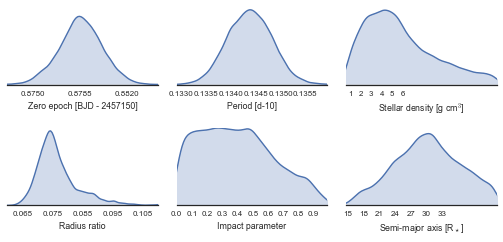

In [54]:
sb.set_context('paper')
fig,ax = subplots(2,3, figsize=(AAPGW,AAOCW))

pars = 'tcc pc rho k b a'.split()
labels = ('Zero epoch [BJD - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$]'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    sb.kdeplot(df[par], shade=True, ax=ax.flat[i], legend=False)
    #sb.kdeplot(dfb[par], shade=True, ax=ax.flat[i], legend=False)
    setp(ax.flat[i], xlabel=label, xlim=percentile(df[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in ax.flat]), visible=False)
setp(ax[0,0], xticks=linspace(0.875,0.882, 3))
setp(ax[0,2], xticks=linspace(1,6,6))
setp(ax[1,0], xticks=[0.065,0.075,0.085,0.095,0.105], xlim=(0.06,0.11))
setp(ax[1,1], xticks=linspace(0.,0.9,10))
setp(ax[1,2], xticks=linspace(15,33,7))
fig.tight_layout()
#fig.savefig('basic_parameter_estimates_wn_pub.pdf')

## Plot the light curve

In [7]:
pvs = permutation(fc)[:100]
time_m = linspace(mp[0]-0.03*mp[1], mp[0]+0.03*mp[1], 1500)
mphase_o_d = 24*mp[1]*(fold(lpf.time, mp[1], mp[0], 0.5, normalize=True) - 0.5)
mphase_m_d = 24*mp[1]*(fold(time_m,   mp[1], mp[0], 0.5, normalize=True) - 0.5)

flux_pr = array([lpf.compute_lc_model(pv, time_m) for pv in pvs])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
flux_mo = median(array([lpf.compute_lc_model(pv, time_m) for pv in pvs]), 0)

**NOTE:** The orbital period is close to a multiple of Kepler long cadence exposure duration...

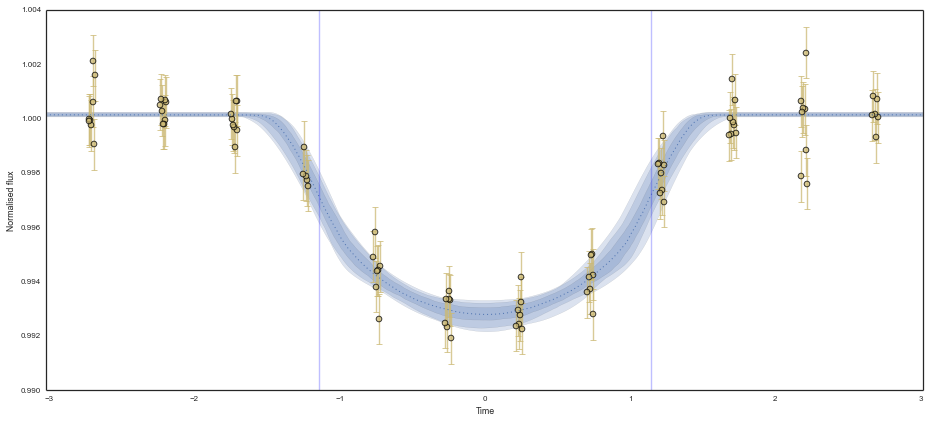

In [9]:
with sb.axes_style('white'):
    fig, ax = subplots(1,1, figsize=(13,6))
    hT14 = 0.5*median(df.T14)
    cp = sb.color_palette()
    sids = argsort(mphase_m_d)
    ax.errorbar(mphase_o_d, lpf.flux, mp[5], fmt='o', c=cp[4], alpha=0.75, markeredgecolor='k', markeredgewidth=1)
    [ax.fill_between(mphase_m_d[sids],*flux_pc[i:i+2,sids],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(mphase_m_d[sids], flux_pc[0,sids], c=cp[0], lw=1, ls=':')
    [ax.axvline(c*hT14, alpha=0.25) for c in [-1,1]]
    setp(ax, xlim=(-3.02,3.02), ylim=(0.99,1.004),xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    fig.savefig('lc_model_wn_crho4.png')

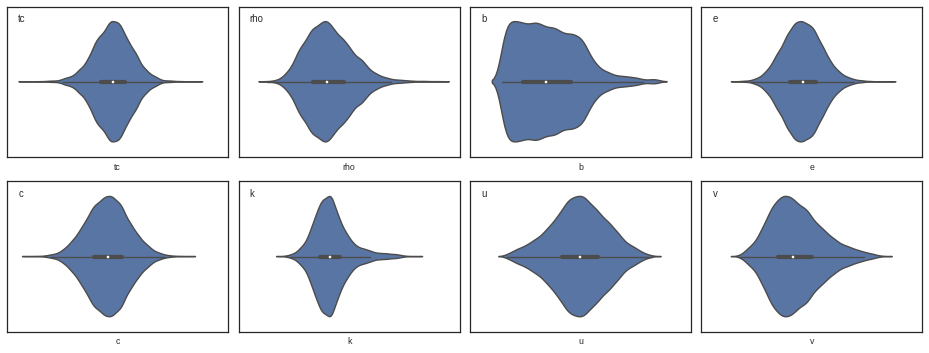

In [9]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5))
    pars = 'tc rho b e c k u v'.split()
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

In [146]:
def ms(df,p):
    p = array(percentile(df[p], [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()

def create_row(df,pars):
    return ('<tr>'+
            ''.join(['<td>{:5.4f} &plusmn; {:5.4f}</td>'.format(*ms(df,p)) for p in pars])+
            '</tr>')

def create_table(df):    
    pars = 'tc p rho b k T14 a I'.split()
    return ('<table style="width:100%">'+
            ''.join(['<th>{:}</th>'.format(p) for p in pars])+
            create_row(df,pars)+
            '</table>')

In [18]:
display(HTML(create_table(df)))

2317.8786 ± 0.0014,10.1344 ± 0.0004,4.1400 ± 1.7367,0.3703 ± 0.2950,0.0755 ± 0.0064,2.7590 ± 0.1623,28.2210 ± 4.4826,89.2581 ± 0.8139


In [147]:
print create_table(df)

<table style="width:100%"><th>tc</th><th>p</th><th>rho</th><th>b</th><th>k</th><th>T14</th><th>a</th><th>I</th><tr><td>2317.8787 &plusmn; 0.0014</td><td>10.1344 &plusmn; 0.0004</td><td>4.2522 &plusmn; 1.6465</td><td>0.3492 &plusmn; 0.2873</td><td>0.0753 &plusmn; 0.0059</td><td>2.7522 &plusmn; 0.1539</td><td>28.4745 &plusmn; 4.1293</td><td>89.3034 &plusmn; 0.7579</td></tr></table>


In [19]:
HTML(create_table(df))

2317.8787 ± 0.0014,10.1344 ± 0.0004,4.0891 ± 1.8785,0.3862 ± 0.3146,0.0758 ± 0.0073,2.4863 ± 0.1164,28.1045 ± 5.0655,89.2200 ± 0.9257
